In [2]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

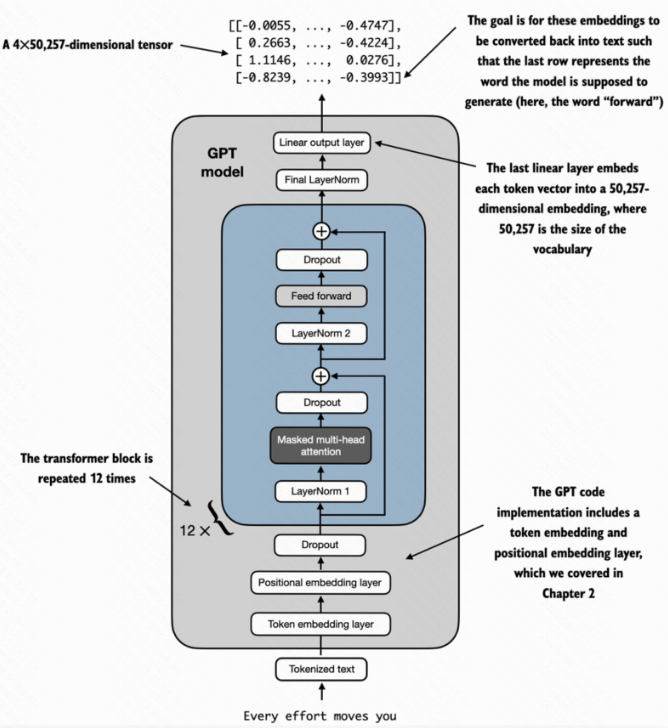

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        print(f"[DummyGPTModel] input shape: \n{in_idx.shape}")
        
        # 得到 token emb
        tok_embs = self.tok_emb(in_idx)
        pos_embs = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embs + pos_embs
        print(f"[DummyGPTModel] output shape after token and position embedding: \n{x.shape}")
        
        # 这里要对 token emb 做 dropout
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        print(f"[DummyGPTModel] output shape after transformer blocks: \n{x.shape}")
        # trf 后会做一次 LayerNorm
        x = self.final_norm(x)
        print(f"[DummyGPTModel] output shape after final norm: \n{x.shape}")
        # 最后需要对齐 context_length
        logits = self.out_head(x)
        print(f"[DummyGPTModel] output shape after out head: \n{logits.shape}")
        
        return logits

In [4]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self, x):
        return x

In [5]:
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()
        
    def forward(self, x):
        return x

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2  = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

# print(f"batch shape: {len(batch)}")
batch = torch.stack(batch, dim=0)
print(f"batch shape: {batch.shape}")
print(f"batch: {batch}")

batch shape: torch.Size([2, 4])
batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(f"output shape: {logits.shape}")
# print(f"logits: {logits}")

[DummyGPTModel] input shape: 
torch.Size([2, 4])
[DummyGPTModel] output shape after token and position embedding: 
torch.Size([2, 4, 768])
[DummyGPTModel] output shape after transformer blocks: 
torch.Size([2, 4, 768])
[DummyGPTModel] output shape after final norm: 
torch.Size([2, 4, 768])
[DummyGPTModel] output shape after out head: 
torch.Size([2, 4, 50257])
output shape: torch.Size([2, 4, 50257])


In [8]:
 class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # 避免归一化时除 0
        self.eps = 1e-5
        # scale 和 shift 是可学习的参数，可以提高模型的训练效率
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        x = self.scale * norm_x + self.shift
        
        return x     

In [9]:
# 一种比 ReLU 平滑性更好的激活函数，有利于提升训练效率
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715  * torch.pow(x, 3))))

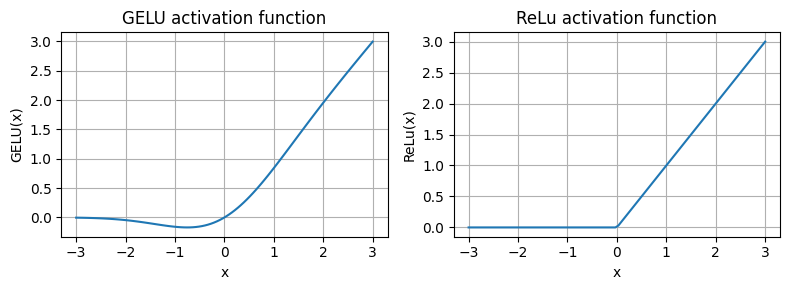

In [10]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)   

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLu"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    
plt.tight_layout()
plt.show()

In [11]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
        
    def forward(self, x):
        return self.layers(x)

In [12]:
import torch.nn as nn
import torch

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        # 每个头的维度
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        # 使用一个 projection 层将所有头的输出合并
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(p=dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # 将 d_out 展开为 (num_heads, head_dim)
        # 最终得到维度 (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # 转置使得维度变为 (b, num_heads, num_tokens, head_dim)
        # (num_heads, head_dim) 可以按照原来方法计算
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # 计算每个头的注意力分数
        attn_scores = queries @ keys.transpose(2, 3)
        mask_pool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_pool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # attn_weight @ values 的结果维度为 (b, num_heads, num_tokens, head_dim)
        # 通过转置，得到 (b, num_tokens, num_heads, head_dim)
        context_vecs = (attn_weights @ values).transpose(1, 2)
        # 将 context_vecs 的维度从 (b, num_heads, num_tokens, head_dim) 转换为 (b, num_tokens, d_out)
        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)
        
        # 添加一层 linear projection 变换，但保证输出维度仍然是 (b, num_tokens, d_out)
        context_vecs = self.out_proj(context_vecs)
        
        return context_vecs

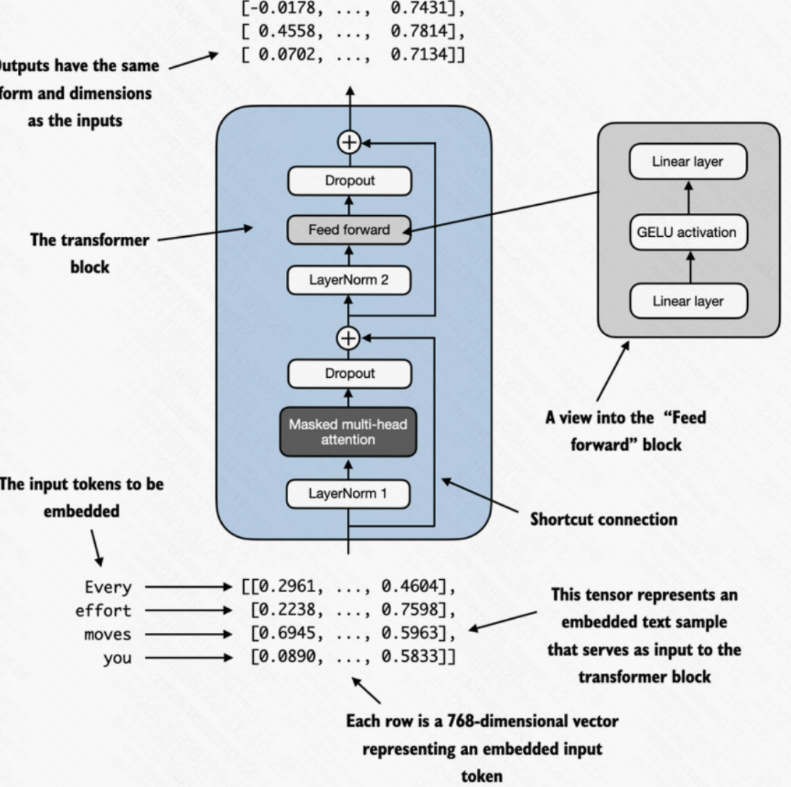

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attr = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            num_heads= cfg['n_heads'],
            dropout = cfg['drop_rate'],
            qkv_bias = cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attr(x)
        x = self.drop_shortcut(x) + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x) + shortcut
        
        return x

In [14]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print(f"input shape: {x.shape}")
print(f"output shape: {output.shape}")

input shape: torch.Size([2, 4, 768])
output shape: torch.Size([2, 4, 768])


In [15]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
        
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print(f"input shape: {batch.shape}")
print(f"input: {batch}")

print(f"output shape: {out.shape}")
print(f"output: {out}")


input shape: torch.Size([2, 4])
input: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
output shape: torch.Size([2, 4, 50257])
output: tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [17]:
# 参数分析
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params:,}")

# print(f"token embedding layer shape: {model.tok_emb.weight.shape}")
# print(f"output layer shape: {model.out_head.weight.shape}")

# gpt2 的架构中，out_head 层复用了 tok_emb 层的参数，所以可以减去 out_head 层的参数数量
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())

# 最终的 gpt2 模型的参数数量是 124M
print(f"Total parameters in GPT-2 model (excluding output layer): {total_params_gpt2:,}")

# token emb 的参数量
total_emb_params = sum(p.numel() for p in model.tok_emb.parameters())
print(f"Total parameters in token embedding layer: {total_emb_params:,}")

# pos emb 的参数量    
total_pos_params = sum(p.numel() for p in model.pos_emb.parameters())
print(f"Total parameters in position embedding layer: {total_pos_params:,}")

# drop_emb 的参数
total_drop_emb_params = sum(p.numel() for p in model.drop_emb.parameters())
print(f"Total parameters in dropout embedding layer: {total_drop_emb_params:,}")

# trf_blocks 的参数量
total_trf_params = sum(p.numel() for p in model.trf_blocks.parameters())
print(f"Total parameters in transformer blocks: {total_trf_params:,}")

# layer_norm 的参数量
total_layer_norm_params = sum(p.numel() for p in model.final_norm.parameters())
print(f"Total parameters in layer normalization: {total_layer_norm_params:,}")

# out_head 的参数量
total_out_params = sum(p.numel() for p in model.out_head.parameters())
print(f"Total parameters in output head: {total_out_params:,}")

# 模型的总大小
total_size = total_params * 4 / (1024 ** 2)
print(f"Total model size: {total_size:.2f} MB")

Total parameters in the model: 163,009,536
Total parameters in GPT-2 model (excluding output layer): 124,412,160
Total parameters in token embedding layer: 38,597,376
Total parameters in position embedding layer: 786,432
Total parameters in dropout embedding layer: 0
Total parameters in transformer blocks: 85,026,816
Total parameters in layer normalization: 1,536
Total parameters in output head: 38,597,376
Total model size: 621.83 MB


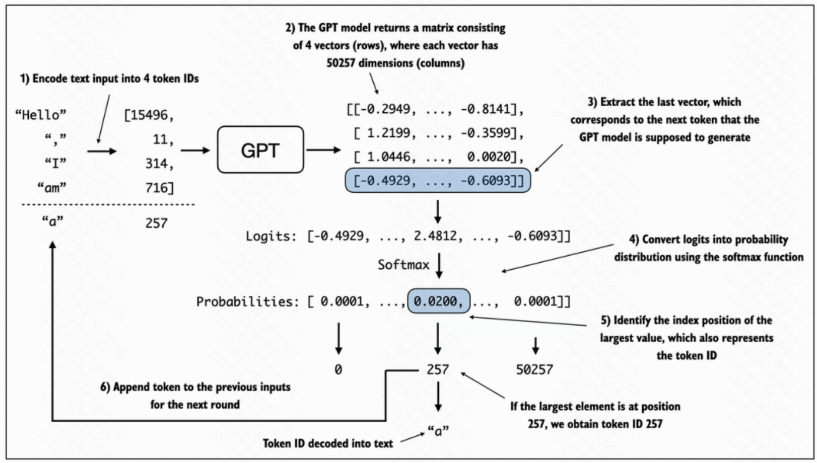

In [21]:
def generate_simple_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim = -1)
        idx_next = torch.argmax(probas, dim = -1, keepdim = True)
        idx = torch.cat((idx, idx_next), dim = 1)
    
    return idx

In [24]:
start_context = "hello, I am"
encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"encoded_tensor.shape: {encoded_tensor.shape}")

model.eval()
out = generate_simple_text(
    model = model, 
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print(f"output: {out}")

decoded_text =tokenizer.decode(out[0].tolist())
print(f"{decoded_text}")

encoded: [31373, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
output: tensor([[31373,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
hello, I am Featureiman Byeswickattribute argue
